This Notebook exemplifies using the learned primal-dual reconstruction method on the LoDoPaB-CT dataset

# Imports

In [1]:
import odl
import numpy as np
import torch
import torch.nn as nn
from primaldual import LearnedPrimalDual
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.transforms import ToTensor
import torchvision
from tqdm.auto import tqdm
import torch

# Parameters
(not necessarily good settings)

In [2]:
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
NUM_EPOCHS = 2

# Helper functions

In [3]:
def to_np(tensor):
    return tensor.cpu().detach().numpy()

def show_img(tensor, title=None):
    plt.figure()
    plt.imshow(to_np(tensor), cmap='Greys_r')
    plt.title(title)
    plt.show()

# Setting up ODL operators

In [4]:
class adj_FFT_subsampling(odl.Operator):
    def __init__(self, range, mask=1.0+0.0j):
        
        domain = odl.uniform_discr(min_pt=[0.,0.], max_pt=[27.,54.], shape=(range.shape[0],2*range.shape[1]),
                          dtype=np.float32)
        
        super(adj_FFT_subsampling, self).__init__(
                domain, range, linear=True)
        
        self.shape = range.shape
        self.mask = mask
        
    def _call(self, x, out, **kwargs):
        t = x.asarray()
        tmp = t[:,:self.shape[1]]+1.0j*t[:,self.shape[1]:]
        tmp = tmp*self.mask
        out[:] = np.real(np.fft.ifft2(tmp,norm = 'ortho'))
    
    @property
    def adjoint(self):
        return FFT_subsampling(domain=self.range, mask = self.mask)
    


In [5]:
class FFT_subsampling(odl.Operator):
    def __init__(self, domain, mask=1.0+0.0j):
        
        range = odl.uniform_discr(min_pt=[0.,0.], max_pt=[27.,54.], shape=(domain.shape[0],2*domain.shape[1]),
                          dtype=np.float32)
        
        super(FFT_subsampling, self).__init__(
                domain, range, linear=True)
        
        self.shape = domain.shape
        self.mask = mask
        
    def _call(self, x, out, **kwargs):
        tmp = np.fft.fft2(x.asarray(),norm = 'ortho')
        tmp = tmp*self.mask
        out[:] = np.concatenate([np.real(tmp), np.imag(tmp)], axis=1)
        
    
    @property
    def adjoint(self):
        return adj_FFT_subsampling(range=self.domain, mask = self.mask)

In [9]:
# ~26cm x 26cm images
MIN_PT = [-0.13, -0.13]
MAX_PT = [0.13, 0.13]

# image shape for simulation
IM_SHAPE = (28, 28)

mask = np.zeros(IM_SHAPE, dtype = np.complex64)

mask[0:5,:] = 1
mask[12:14,:] = 1
#mask[:]=1

space = odl.uniform_discr(min_pt=MIN_PT, max_pt=MAX_PT, shape=IM_SHAPE,
                          dtype=np.float32)

fw_op = odl.operator.default_ops.IdentityOperator(space)
fw_op = FFT_subsampling(space,mask)
adj_fw_op = adj_FFT_subsampling(space,mask)


# Create LoDoPaB-CT Datasets

In [10]:
class custom_dataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        x, y = self.dataset.__getitem__(idx)
        y = fw_op(x.squeeze()).asarray()
        #y = np.concat()
        return y, x.squeeze()
        #return x.squeeze()+0.2*(x.max()-x.min())*torch.randn(*x.squeeze().shape), x.squeeze()

In [11]:
training_dataset = torchvision.datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)




training_dataset = custom_dataset(training_dataset)
#training_dataset, valid_dataset = torch.utils.data.random_split(training_dataset, [len(training_dataset)//2,len(training_dataset)-len(training_dataset)//2])
training_dataset, valid_dataset = torch.utils.data.random_split(training_dataset, [100,len(training_dataset)-100])


Training data loader

In [12]:
data_loader = DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True)

Validation data loader

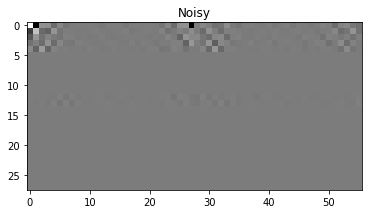

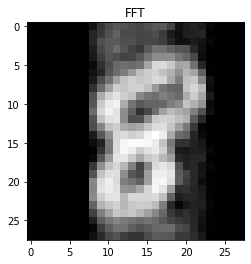

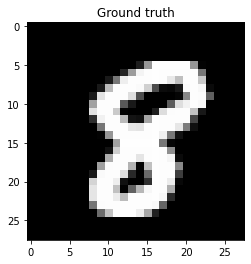

In [13]:
show_img(torch.tensor(training_dataset[0][0]), 'Noisy')
show_img(torch.tensor(adj_fw_op(training_dataset[0][0]).asarray()), 'FFT')
show_img(training_dataset[0][1], 'Ground truth')

# Set up neural net

In [14]:
class PinballLoss():
    def __init__(self, quantile=0.10, reduction='mean'):
        self.quantile = quantile
        assert 0 < self.quantile
        assert self.quantile < 1
        self.reduction = reduction
        
    def __call__(self, output, target):
        assert output.shape == target.shape
        loss = torch.zeros_like(target, dtype=torch.float)
        error = output - target
        smaller_index = error < 0
        bigger_index = 0 < error
        loss[smaller_index] = self.quantile * (abs(error)[smaller_index])
        loss[bigger_index] = (1-self.quantile) * (abs(error)[bigger_index])
        
        if self.reduction == 'sum':
            loss = loss.sum()
        if self.reduction == 'mean':
            loss = loss.mean()
        
        return loss

In [15]:
class pd_model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.q_hi = LearnedPrimalDual(fw_op)
        self.q_low = LearnedPrimalDual(fw_op)
        self.mean = LearnedPrimalDual(fw_op)
        
        
    def forward(self, x):
        lower = self.q_low(x)
        upper = self.q_hi(x)
        pred = self.mean(x)
        
        lower = torch.minimum(pred-1e-6,lower)
        upper = torch.maximum(pred+1e-6,upper)
        
        return lower, pred, upper

In [19]:
alpha = 0.1
def my_loss(pred, target):
    q_lo_loss = PinballLoss(quantile=alpha/2)
    q_hi_loss = PinballLoss(quantile=1-alpha/2)
    mse_loss = torch.nn.MSELoss()
    return q_lo_loss(pred[0],target) + mse_loss(pred[1],target) + q_hi_loss(pred[2],target)

model = pd_model()

# Create training loop

In [20]:
loss_curve = []
epoch = 0
optimizer = torch.optim.Adam(
    list(model.parameters()),
    lr=LEARNING_RATE)

In [21]:
model.to('cuda:0')
model = model.train()
num_epochs = NUM_EPOCHS
for epoch in range(1,num_epochs+1):
    print('Epoch: '+str(epoch)+'/'+str(num_epochs))
    for (noisy, ground_truth) in tqdm(data_loader):
        # add channel dimensions
        noisy = torch.unsqueeze(noisy, 1).to('cuda:0') 
        ground_truth = torch.unsqueeze(ground_truth, 1).to('cuda:0')

        output = model(noisy)
        loss = my_loss(output,ground_truth)
        model.zero_grad()
        loss.backward()
        optimizer.step()

torch.save(model.state_dict(), 'model.pt')

Epoch: 1/2


  0%|          | 0/2 [00:00<?, ?it/s]

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 5.80 GiB total capacity; 4.16 GiB already allocated; 12.19 MiB free; 4.18 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

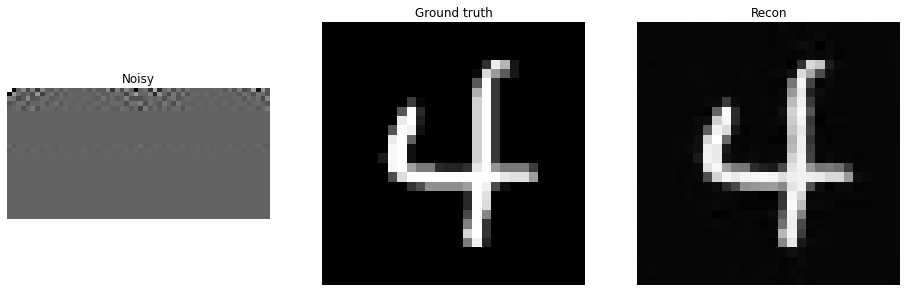

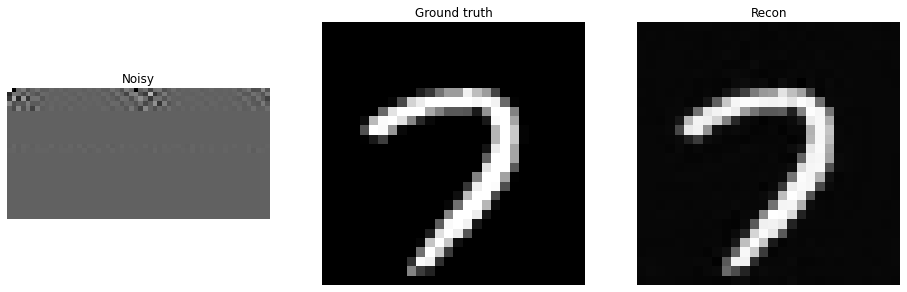

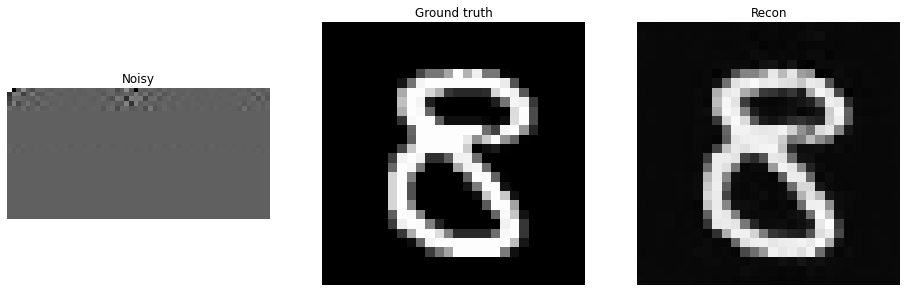

In [760]:
sample_idx = torch.randint(len(valid_dataset), size=(10,))
cols = 3
model.to('cpu')
with torch.no_grad():
    for i in range(3):
        noisy,img = valid_dataset[sample_idx[i].item()]
        figure = plt.figure()
        figure.set_size_inches(16, 10)
        figure.add_subplot(1, cols, 1)
        plt.axis("off")
        plt.title('Noisy')
        plt.imshow(noisy.squeeze(), cmap="gray")
        figure.add_subplot(1, cols, 2)
        plt.axis("off")
        plt.title('Ground truth')
        plt.imshow(img.squeeze(), cmap="gray")
        figure.add_subplot(1, cols, 3)
        plt.axis("off")
        plt.title('Recon')
        plt.imshow(model(torch.unsqueeze(torch.unsqueeze(torch.tensor(noisy),0), 0)).squeeze(), cmap="gray")
        plt.show()